## **Context:**

Can you differentiate a weed from a crop seedling?The ability to do so effectively can mean better crop yields and better stewardship of the environment.The Aarhus University Signal Processing group, in collaboration with University of Southern Denmark, has recently released a dataset containing images of unique plants belonging to 12 species at several growth stagesObjective:To implement the techniques learnt as a part of the course.Learning Outcomes:Pre-processing of image data.Visualization of images.Building CNN.Evaluate the Model.The motive of the project is to make the learners capable to handle images/image classification problems, during this process you shouldalso be capable to handle real image files, not just limited to a numpy array of image pixel

## **Import Required Libraries**

In [1]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import svm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow

In [2]:
# turn off warnings. 
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

In [3]:
# mount to the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# load the label data as csv
label = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Raw Files/Project 7 - CNN/Labels.csv')    # Load the dataset by providing the path to the file.

In [5]:
# load numpy images dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/Raw Files/Project 7 - CNN/images.npy')

In [6]:
# look at the length/number of rows in the images dataset
print("The Length of the Plant Seed Data is: ")
len(images)

The Length of the Plant Seed Data is: 


4750

### **Shape of the Image**

In [7]:
print('The shape of image is: ', images.shape)
# Extracting the height and width of an image 
h, w = images.shape[:2] 
# Displaying the height and width 
print("Height = {},  Width = {}".format(h, w)) 
#images.shape

The shape of image is:  (4750, 128, 128, 3)
Height = 4750,  Width = 128


Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

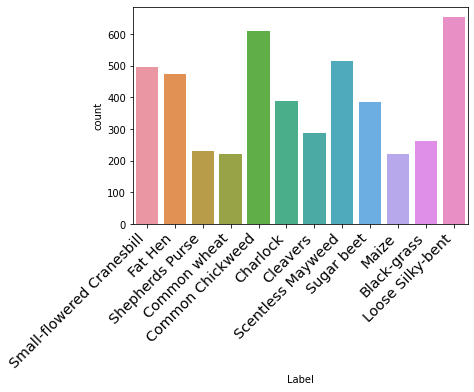

In [8]:
## a countplot for the labels. This will give a better idea of the data distribution. 
g = sns.countplot(label['Label']);
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
label['Label'].value_counts()

Shepherds Purse and Common wheat account for the least amount of the labels.

### **View of Images**

I will take a look at the images within the dataset. Given that there are a large number of images (4750) within the dataset I will take a look at the first 20 images within the data.

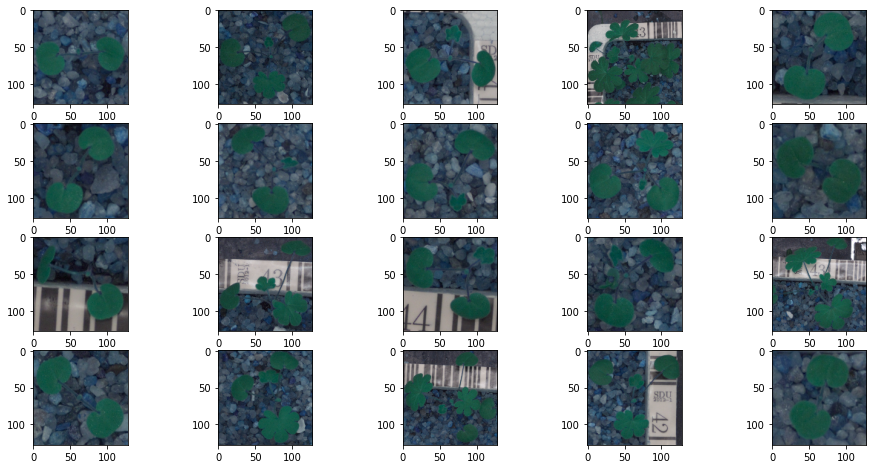

In [9]:
# a visual of the images
plt.figure(figsize=(16, 8)) 
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(images[i])
  

## **Data Pre-processing**

### **Normalization**

We will normalize our data as it is a general requirement for neural network models. 

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process.
As such it is good practice to normalize the pixel values so that each pixel value has a value between 0 and 1.

This can be achieved by dividing the RGB codes by 255, as this is the maximum RGB code. We also need to ensure that the values are in float format so we can get decimal points after division. 

In [10]:
# Normalize the data and conver to float. 
X = images.astype('float32') / 255.0

### **Examining the Pixel Values:**

We will take a look at the distribution of the pixels using a histogram. However, in order to do so, we will need to reshape the images from a 4D array to a 2D array

Note that these images aren't actually black and white (0,1). They are gray-scale (0-255).
A histogram of this image's pixel values shows the range.

In [11]:
## reshpae X (images dataset) to a 2-D array, which will take size 4750*49152. We will create an empty array of this size
x_reshaped = X.reshape((4750,49152))

In [12]:
# check the min and the max of the reshaped array.
print('Min: %.3f, Max: %.3f' % (x_reshaped.min(), x_reshaped.max()))

Min: 0.000, Max: 1.000


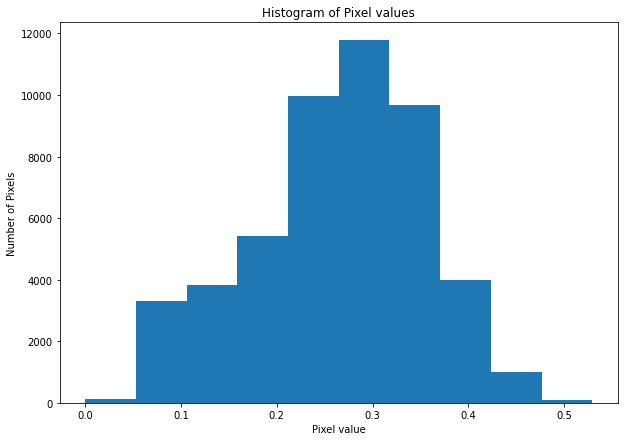

In [13]:
# the following code will allow us to visualize the pixel values using a histogram
plt.figure(figsize=(10,7), edgecolor='blue') # adjusting the figure size and the color of the bars
counts, bins, bars = plt.hist(x_reshaped[i])
plt.xlabel('Pixel value')
plt.ylabel('Number of Pixels')
plt.title('Histogram of Pixel values')
plt.show()

• Given that we have normalized the data, the pixel values will range from 0-1. A zero represents a color of black and a 1 represents a color of white.
 
• Looking at the histogram the pixel values look to be of darker colors given that they are primarily in the range of 0.2-0.4

## **Using Gaussian Blurring in Pre-Processing:**

We will now use gaussian blurring using a vectorized operations approach (VEC). When working with images our main interest is to be able to identify objects (in this case plant labels) within the image. We look to identify edges, which represent a transition from one group of similar pixels in the image to another different group. Blurring an image allows us to make the transition from one side of an edge in the image to another, which is more smooth rather than sudden. The effect is to average out rapid changes in pixel intensity. The smoothing of images removes 'Outliers' pixels that may be a form of noise in the image. Gaussian blurring is thus an appraoch taken to reduce the noise from an image. This is often referred to as a 'low-pass filter'. 

A VEC approach is recommended when working with arrays, as it is computaitonally faster. The data within arrays is homogenous (unlike lists) and therefore it will not have to check for the data type of every one of the items as it iterates over the arrays

In [14]:
# a check for the number of dimensions within the data
print('The number of dimensions is: ')
X.ndim

The number of dimensions is: 


4

In [15]:
# using the Gaussian Blurring Vectorized Approach.
X_new = np.apply_along_axis(
    lambda img: cv2.GaussianBlur(img, (5, 5), 0), 
    -1, 
    X.reshape((-1, 128, 128))
)
X_new = X_new.reshape((-1, 128, 128,3))

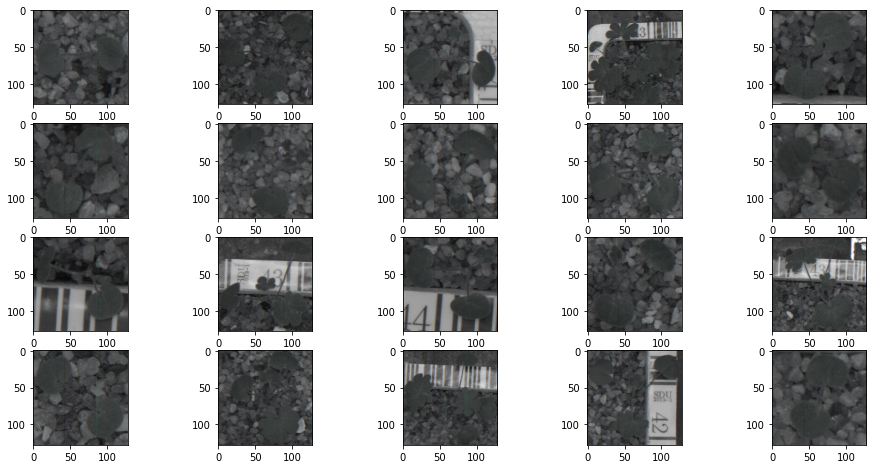

In [16]:
# a visual of the images
plt.figure(figsize=(16, 8)) 
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.imshow(X_new[i])

**Examining the Pixel Values:**

We will now examine the pixel values after applying the Gaussing blurring. We will use a histogram to do this.   

In [17]:
new2 = X_new.reshape((4750,49152))

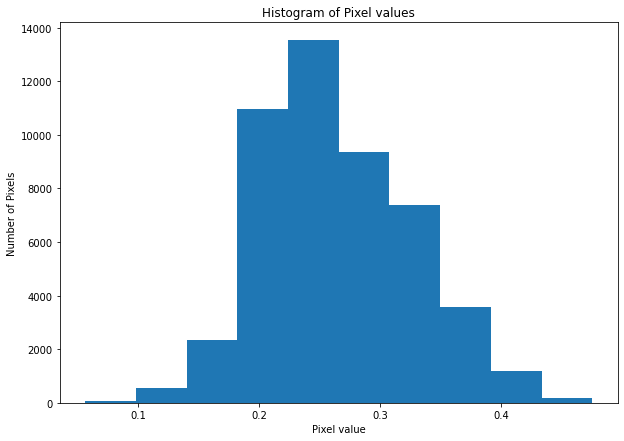

In [18]:
plt.figure(figsize=(10,7), edgecolor='blue') # adjusting the figure size and the color of the bars
counts, bins, bars = plt.hist(new2[i])
plt.xlabel('Pixel value')
plt.ylabel('Number of Pixels')
plt.title('Histogram of Pixel values')
plt.show()

### **Results of Gaussian Blurring**

Looking at the images after applying gaussian blurring it is quite clear that the images are now more blurred and less cear to the human eye. There are also clear differences with the histogram results that identify the pixel values. There is now minimal zero values, identify black colors. Still there are no high pixel values which imply there are no white colors.  

## **Make data compatible:**

a.Convert labels to one-hot-vectors.

b.Print the label for y_train[0].

c.Split the dataset into training,testing, and validation set.(Hint: First split images andlabels into training and testing set with test_size = 0.3. Then further split test data into test and validation set with test_size = 0.5)

d.Check  the  shape  of  data, Reshape  data  into  shapes compatible with Keras models if it’s not already. If it’s already in the compatible shape, then comment in the notebook that it’s already in compatible shape

### **One-hot encode for the Lables**

We’ll need to use one hot encoding to convert the labels to a multi class matrix. Using one hot encoding, additioanl columns will be created (one for each class).

Given that the labels data is currently not in integer format i.e currently as string, we will need to use the get_dummies approach through pandas. We will not be able to use the tensorflow to_categorical library. 

We will first convert the labels data to a numpy array as it will need to be in this format to be fed into the model.


In [19]:
# # Convert the labels to numpy array to feed into the model. 
y = label.values 

In [20]:
#check the data type to ensure its as an array
print(type(y))

<class 'numpy.ndarray'>


In [21]:
#creating dummy variables for the categorical features
label_origional = label #create a copy of the origional labels data
y = pd.get_dummies(label,drop_first=False) #create dummies 
y = y.astype('float32') # we will need to convert the dataset to float in order to cater to tensorflow
y.head()

,Label_Black-grass,Label_Charlock,Label_Cleavers,Label_Common Chickweed,Label_Common wheat,Label_Fat Hen,Label_Loose Silky-bent,Label_Maize,Label_Scentless Mayweed,Label_Shepherds Purse,Label_Small-flowered Cranesbill,Label_Sugar beet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### **The shape of the y_train as well as the label for the y_train[0]**

In [22]:
# print the shape of the y_train as well as the label for the y_train[0]
print("Shape of y_train:", y.shape)
print('#############################################')
print("The label for y_train[0] is:",y.loc[0].eq(1.0).idxmax())

Shape of y_train: (4750, 12)
#############################################
The label for y_train[0] is: Label_Small-flowered Cranesbill


### **Split the Data into Training, Test & Validation**

In [23]:
# Split data into test and train to build the model. 
# In the first step we will split the data in training and remaining dataset (rem refers to remaining)
X_train, X_rem, y_train, y_rem  = train_test_split(X,y, test_size=0.3, random_state=0)

In [24]:
# Now since we want the valid and test size to be equal (15% each of overall data). 
# we have to define test_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

### **Check  the  shape  of  data, Reshape  data  into  shapes compatible with Keras models if it’s not already. If it’s already in the compatible shape, then comment in the notebook that it’s already in compatible shape**

In [25]:
print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(3325, 128, 128, 3)
(3325, 12)
(712, 128, 128, 3)
(712, 12)
(713, 128, 128, 3)
(713, 12)


(None, None)

In [26]:
# checking the number of dimensions
X_train.ndim

4

### **Data Compatibility**

For CNN the input layer must be a 4D array, consisting of the batch size, the weight, hight and the depth. The depth refers to the number of color channels (RGB channels). The batch size refers to the number of images used to train a single forward and backward pass. Given that our dataset has 4 dimensions it is compatable with Keras to build the CNN model.  

## **Building CNN**

In [27]:
from tensorflow.keras.models import Sequential          # Sequential groups a linear stack of layers into a tf.keras.Model.
from tensorflow.keras.layers import Conv2D              # This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
from tensorflow.keras.layers import MaxPooling2D        # Max pooling operation for 2D spatial data.
from tensorflow.keras.layers import Flatten             # Flattens the input. Does not affect the batch size.
from tensorflow.keras.layers import Dense, Dropout      # Dropout: Applies Dropout to the input.
                                                        # Dense: Just your regular densely-connected NN layer.

### **Define Layers**

Please note that for this assignment, we have 3 datasets; train, validation and test datasets as advised. It does not explicity advise as to whether we should test the performance on the validation data or test data. For the purpose of this assignment we will take the following approach:

We will train a CNN model using the training dataset and test on the validation data set. We will then look to improve the model using forms of hyper paramater tuning. Using the model that performs best on the validation data set, we will evaluate the performance of this model on test data set, to predict certain images. We will first define the layers that will be used:

Convolutional Layer - this is the initial layer that the input image is fed to, in order to extract features. A filter/kernel is applied to input it order to extract features. The output of features is referred to as a feature map.

Max Pooling Layer - max pooling is a pooling type layer. Pooling layers provide an approach to down sampling feature maps by summarizing the presence of features in patches of the feature map. In he case of max pooling, we take the maximum value for each patch of the feature map.

Dropout Layer -  the dropout layer is used to help reduce overfitting. It does this by randomly dropping out nodes during training. 

Flatten Layer - this is one of the last steps of the CNN approach. It reduces the date to a 1_dimensional linear vector to be fed into the fully connected/dense layer to perform the classifcation. 

Dense Layer - Fully Connected Layers form the last few layers in the network. The input to the fully connected layer is the output from the final Pooling or flattening layer. 


In [28]:
# Initialising the CNN classifier
classifier = Sequential()

# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), input_shape = (128,128, 3), activation = 'relu', padding = 'same'))

# Add a Max Pooling layer of size 2X2
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'valid'))

# Adding another pooling layer
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the layer before fully connected layers
classifier.add(Flatten())

# Adding a fully connected layer with 512 neurons
classifier.add(Dense(units = 512, activation = 'relu'))

# Adding dropout with probability 0.5
classifier.add(Dropout(0.5))


# Adding a fully connected layer with 128 neurons
classifier.add(Dense(units = 128, activation = 'relu'))


# The final output layer with 10 neurons to predict the categorical classifcation
classifier.add(Dense(units = 12, activation = 'softmax'))

### **Set optimizer and loss function**

• The loss function that we will use is categorical_crossentroy. This is used as a loss function for multi-class classification model where there are two or more output labels. Given that we have 12 different classes, this is a good choice to use.

• For the optimizer we will use the Adam optimizer which adaptive learning rate optimization algorithm. It uses the squared gradients to scale the learning rate and it takes advantage of momentum by using moving average of the gradient instead of gradient itself.

In [29]:
''' Compile model (using the efficient Adam gradient descent optimization algorithm
    with a logarithmic loss function, which is called “categorical_crossentropy” in Keras.)'''
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## **Fit and evaluate modeland print confusion matrix**

In [58]:
# fit the model
classifier.fit( x=X_train, y=y_train, batch_size=32, epochs=64, validation_split = 0.30)

Epoch 1/64
89/89 [==============================] - 2s 22ms/step - loss: 0.0248 - accuracy: 0.9926 - val_loss: 1.3624 - val_accuracy: 0.7956
Epoch 2/64
89/89 [==============================] - 2s 20ms/step - loss: 0.0345 - accuracy: 0.9873 - val_loss: 1.2811 - val_accuracy: 0.8076
Epoch 3/64
89/89 [==============================] - 2s 20ms/step - loss: 0.0415 - accuracy: 0.9866 - val_loss: 1.3696 - val_accuracy: 0.7796
Epoch 4/64
89/89 [==============================] - 2s 20ms/step - loss: 0.0312 - accuracy: 0.9919 - val_loss: 1.1351 - val_accuracy: 0.8076
Epoch 5/64
89/89 [==============================] - 2s 21ms/step - loss: 0.0435 - accuracy: 0.9873 - val_loss: 1.4483 - val_accuracy: 0.7856
Epoch 6/64
89/89 [==============================] - 2s 21ms/step - loss: 0.0549 - accuracy: 0.9823 - val_loss: 0.9857 - val_accuracy: 0.8116
Epoch 7/64
89/89 [==============================] - 2s 20ms/step - loss: 0.0394 - accuracy: 0.9851 - val_loss: 1.1725 - val_accuracy: 0.8136
Epoch 8/64
89

### **Once the model has been fit we will evaluate the performance on the validation dataset**

In [59]:
# we will use scorese to capture the accuracy of the model on the validation data. 
scores = classifier.evaluate(X_valid,y_valid, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 9ms/step - loss: 1.4413 - accuracy: 0.7851
Test loss: 1.4413268566131592
Test accuracy: 0.7851123809814453


In [32]:
# import confusion matrix 
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
# define a variable for the prediction on the validation data
y_pred = np.round(classifier.predict(X_valid),0)

In [34]:
# print y_pred
print(y_pred)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [35]:
#need to convert y_valid2 to a numpy array so its consistent for a confusion matrix.
y_valid2 = y_valid.values

In [36]:
# print the 
print("=== Confusion Matrix ===")
cm = confusion_matrix(y_valid2.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

=== Confusion Matrix ===
[[17  0  0  1  1  1 15  0  0  0  1  1]
 [ 0 63  0  0  0  1  0  0  0  0  0  4]
 [ 0  1 36  0  2  0  0  0  2  1  0  1]
 [ 1  0  0 82  0  1  0  1  1  3  1  0]
 [ 3  0  0  0 15  1  5  0  1  0  0  0]
 [ 2  0  2  0  3 67  0  0  0  0  2  0]
 [13  0  0  0  1  3 73  0  0  0  1  0]
 [ 1  0  1  1  0  0  0 21  4  0  0  3]
 [ 1  6  1  2  0  1  2  3 61  2  1  6]
 [ 0  1  1  2  0  0  0  1  3 15  4  0]
 [ 0  0  0  0  0  0  0  2  0  0 71  0]
 [ 2  0  0  2  1  0  0  2  2  0  2 54]]


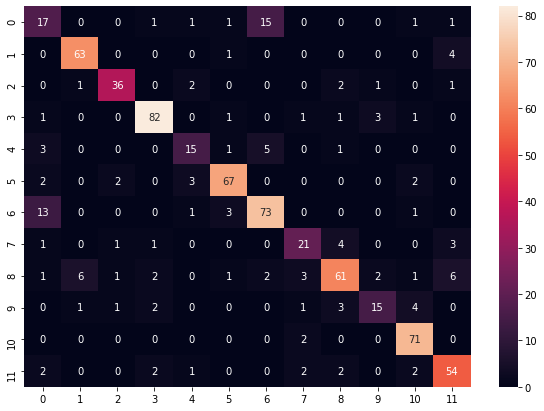

In [37]:
# heatmap may make this easier to interpret. 
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d')

### **We will reavulate the performance using Early Stopping**

In [60]:
# Initialising the CNN classifier
classifier2 = Sequential()

# Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier2.add(Conv2D(32, (3, 3), input_shape = (128,128, 3), activation = 'relu', padding = 'same'))

# Add a Max Pooling layer of size 2X2
classifier2.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier2.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))

# Adding another pooling layer
classifier2.add(MaxPooling2D(pool_size = (2, 2)))

# Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
classifier2.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'valid'))

# Adding another pooling layer
classifier2.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the layer before fully connected layers
classifier2.add(Flatten())

# Adding a fully connected layer with 512 neurons
classifier2.add(Dense(units = 512, activation = 'relu'))

# Adding dropout with probability 0.5
classifier2.add(Dropout(0.5))


# Adding a fully connected layer with 128 neurons
classifier2.add(Dense(units = 128, activation = 'relu'))


# The final output layer with 10 neurons to predict the categorical classifcation
classifier2.add(Dense(units = 12, activation = 'softmax'))

In [61]:
#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves a new low value. 
#Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto')

In [62]:
''' Compile model (using the efficient Adam gradient descent optimization algorithm
    with a logarithmic loss function, which is called “categorical_crossentropy” in Keras.)'''
classifier2.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [63]:
classifier2.fit( x=X_train, y=y_train, batch_size=32, epochs=64, validation_split = 0.30,
                    callbacks=[early_stopping,model_checkpoint])

Epoch 1/64
73/73 [==============================] - 3s 26ms/step - loss: 2.4121 - accuracy: 0.1581 - val_loss: 2.2934 - val_accuracy: 0.2275

Epoch 00001: val_loss improved from inf to 2.29338, saving model to cifar_cnn_checkpoint_01_loss2.2934.h5
Epoch 2/64
73/73 [==============================] - 2s 22ms/step - loss: 1.8613 - accuracy: 0.3451 - val_loss: 1.5521 - val_accuracy: 0.4188

Epoch 00002: val_loss improved from 2.29338 to 1.55205, saving model to cifar_cnn_checkpoint_02_loss1.5521.h5
Epoch 3/64
73/73 [==============================] - 2s 22ms/step - loss: 1.5220 - accuracy: 0.4581 - val_loss: 1.3154 - val_accuracy: 0.5331

Epoch 00003: val_loss improved from 1.55205 to 1.31536, saving model to cifar_cnn_checkpoint_03_loss1.3154.h5
Epoch 4/64
73/73 [==============================] - 2s 22ms/step - loss: 1.3239 - accuracy: 0.5307 - val_loss: 1.2130 - val_accuracy: 0.5661

Epoch 00004: val_loss improved from 1.31536 to 1.21298, saving model to cifar_cnn_checkpoint_04_loss1.2130

In [64]:
scores = classifier2.evaluate(X_valid,y_valid, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 9ms/step - loss: 1.0154 - accuracy: 0.7795
Test loss: 1.0153772830963135
Test accuracy: 0.7794944047927856


**Insights:** 

Using Early Stopping has reduced the validation losss while keeping the accuracy performance relatively consistent on the validation data. The test loss has reduced from 1.4413 to 1.0154. Further hyperparameter tuning would be recommended, to see if the performance of the model could be improved on the validation data. However, given the computational time, I will proceed with the improved model (that of Ealry Stopping) for the purpose of this assignment. I will now test the performance of this model on the test data.

We will test the results of classifier 2 on the y test to see if there was improvment in the results

In [65]:
# Score of the model on the test data.
scores = classifier2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

23/23 [==============================] - 0s 8ms/step - loss: 1.2337 - accuracy: 0.7321
Test loss: 1.2337313890457153
Test accuracy: 0.7321178317070007


In [66]:
# define a variable for the prediction on the validation data
y_pred2 = np.round(classifier2.predict(X_test),0)

In [68]:
# define variable to convert y_test to a numpy array
y_test2 = y_test.values

In [71]:
# print the 
print("=== Confusion Matrix ===")
cm2 = confusion_matrix(y_test2.argmax(axis=1), y_pred2.argmax(axis=1)) # confusion matrix of the predicted y versus actual
print(cm2)

=== Confusion Matrix ===
[[14  0  0  0  4  2 20  0  1  0  1  1]
 [ 0 37  1  0  0  0  0  0  1  0  2  0]
 [ 1  4 36  1  0  1  0  0  4  0  0  1]
 [ 0  0  0 87  0  0  0  0  4  5  1  0]
 [11  1  0  0 28  2  3  0  1  0  0  0]
 [ 7  2  1  3  1 50  4  1  1  0  0  1]
 [18  0  1  1  1  2 70  0  0  0  1  1]
 [ 5  2  0  4  1  0  0 13  4  1  2  1]
 [ 8  2  0  1  1  1  1  2 56  1  0  1]
 [ 2  1  0  7  0  0  0  0  4 22  1  0]
 [ 0  3  0  2  0  0  0  1  0  1 64  0]
 [ 2  2  1  3  1  1  0  3  3  0  4 37]]


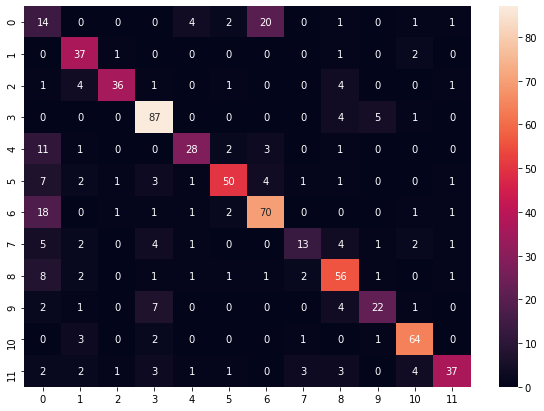

In [72]:
#print the heat map of the confusion matrix on the test data
df_cm2 = pd.DataFrame(cm2)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm2, annot=True, fmt='d')

**Insights:**

The results from on the test data are slightly worse than that on the validation data.  

## **Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]**

Predicted label: 6
Softmax Outputs: [[1.2552637e-03 7.4075327e-17 2.6467294e-13 1.1418405e-06 6.0433405e-09
  1.6929066e-06 9.9874181e-01 5.7412514e-10 2.3471568e-11 4.3274037e-11
  1.3860739e-07 1.4140218e-10]]
1.0000001


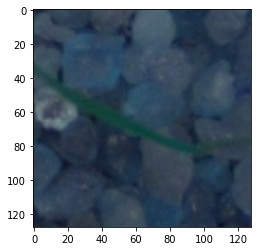

In [44]:
plt.imshow(X_test[2])
y_pred1 = classifier2.predict(X_test[2].reshape(-1,128,128,3))
print("Predicted label:", y_pred1.argmax())
print("Softmax Outputs:", y_pred1)
print(y_pred1.sum())

Predicted label: 8
Softmax Outputs: [[4.5204764e-09 1.7152961e-06 1.2995393e-02 5.8154281e-05 4.1608461e-03
  6.7195862e-05 2.5126288e-09 4.6597538e-03 9.7585809e-01 2.1611007e-03
  3.6928715e-05 8.0036676e-07]]
1.0


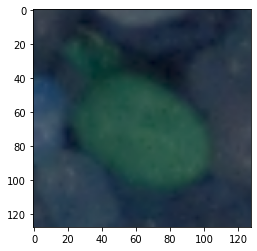

In [45]:
plt.imshow(X_test[3])
y_pred1 = classifier2.predict(X_test[3].reshape(-1,128,128,3))
print("Predicted label:", y_pred1.argmax())
print("Softmax Outputs:", y_pred1)
print(y_pred1.sum())

Predicted label: 5
Softmax Outputs: [[4.0935788e-08 2.5293594e-13 9.2782555e-09 6.4233869e-02 1.2842905e-10
  9.3461782e-01 6.4701885e-06 3.2974509e-07 9.9607815e-09 1.5393568e-06
  2.4745133e-04 8.9249108e-04]]
1.0


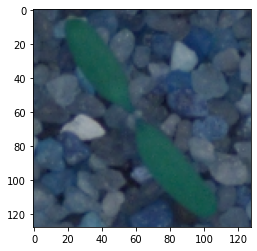

In [46]:
plt.imshow(X_test[33])
y_pred1 = classifier2.predict(X_test[33].reshape(-1,128,128,3))
print("Predicted label:", y_pred1.argmax())
print("Softmax Outputs:", y_pred1)
print(y_pred1.sum())

Predicted label: 3
Softmax Outputs: [[1.27715255e-14 3.18312169e-17 5.99512238e-16 9.99999762e-01
  5.45022740e-19 7.98914623e-09 4.66716997e-13 5.82165294e-09
  5.26059862e-09 2.87520436e-07 1.43799217e-09 2.05201700e-13]]
1.0


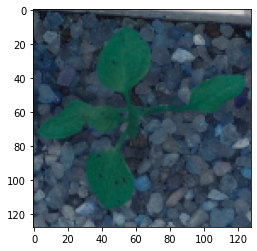

In [47]:
plt.imshow(X_test[36])
y_pred1 = classifier2.predict(X_test[36].reshape(-1,128,128,3))
print("Predicted label:", y_pred1.argmax())
print("Softmax Outputs:", y_pred1)
print(y_pred1.sum())

Predicted label: 3
Softmax Outputs: [[3.7503850e-10 4.0514247e-20 5.8399473e-14 9.9931395e-01 1.2251093e-15
  6.8604812e-04 3.0009158e-11 2.4810634e-09 5.3195595e-12 1.1509530e-09
  1.3833740e-09 1.2103095e-08]]
1.0


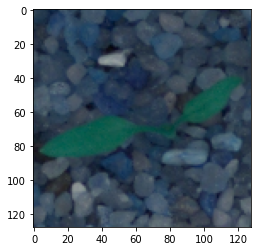

In [48]:
plt.imshow(X_test[59])
y_pred1 = classifier2.predict(X_test[59].reshape(-1,128,128,3))
print("Predicted label:", y_pred1.argmax())
print("Softmax Outputs:", y_pred1)
print(y_pred1.sum())